# Anomaly Detection Pipeline

**Versions Used:**  
- python version 3.12
- Pandas version: 1.4.2  
- Numpy version: 1.21.6  
- Scikit-learn version: 1.0.2  
- TensorFlow version: 2.19.0  
- Joblib version: 1.1.0  
- Matplotlib version: 3.5.1  
- psutil version: 5.8.0  


# Step 1: Import Libraries
Import all necessary libraries for anomaly detection pipeline.

In [59]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import time
import psutil
    

# Step 2: Configuration
Set global paths, constants, and start memory tracking.

In [66]:

DEVICES_DATA_PATH = "../src/devices_data/"
SAVED_MODELS_PATH = "../test_cases/saved_models/"
EXCLUDE_COLUMNS = ['timestamp', 'state', 'reconstruction_error', 'is_anomaly', 'label']
SEQUENCE_LENGTH = 30
ANOMALY_PERCENTILE = 99.5
MIN_ANOMALY_DURATION = 3
ERROR_SMOOTHING_SPAN = 5

global_start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / (1024 * 1024)
    

# Step 3: Utility Functions
Define helper functions with Doxygen-style documentation.

In [67]:

def get_model_name(device_type, state):
    """
    @brief Generate the LSTM model filename based on device type and state.
    @param device_type Type of the device (e.g., 'bale_counter', 'output_sensor').
    @param state Current operational state (e.g., 'run', 'idle').
    @return Model filename as string.
    """
    if device_type == 'bale_counter':
        return f"lstm_{state}_bale_counter.h5"
    elif device_type == 'temperature_sensor':
        return f"lstm_{state}_temperature_sensor.h5"
    elif device_type == 'output_sensor':
        return f"lstm_{state}.h5"
    else:
        return f"lstm_{state}.h5"

def get_rf_model_name(device_type):
    """
    @brief Generate the Random Forest model filename based on device type.
    @param device_type Type of the device.
    @return Model filename as string or None if not defined.
    """
    if device_type == 'bale_counter':
        return "random_forest_bale.pkl"
    elif device_type == 'output_sensor':
        return "random_forest_output_sensor.pkl"
    elif device_type == 'temperature_sensor':
        return "random_forest_temperature_sensor.pkl"
    elif device_type == 'motor_monitor':
        return "random_forest_motor_monitor.pkl" 
    return None


def get_device_files():
    """
    @brief Fetch all device CSV files from the data directory.
    @return List of (device_type, filename) tuples.
    """
    device_files = []
    for file in os.listdir(DEVICES_DATA_PATH):
        if file.endswith("_unified.csv"):
            device_type = file.split('_')[0] + '_' + file.split('_')[1]
            if device_type == "hatch_status":
                continue
            device_files.append((device_type, file))
    return device_files

def get_numerical_features(df):
    """
    @brief Identify numerical sensor columns in a DataFrame.
    @param df Input DataFrame.
    @return List of numerical feature column names.
    """
    return [col for col in df.columns if col not in EXCLUDE_COLUMNS and pd.api.types.is_numeric_dtype(df[col])]

def create_sequences(data, seq_length=SEQUENCE_LENGTH):
    """
    @brief Create rolling sequences of data for LSTM input.
    @param data DataFrame containing features.
    @param seq_length Number of timesteps per sequence.
    @return Numpy array of sequences.
    """
    return np.array([data.iloc[i:i + seq_length].values for i in range(len(data) - seq_length)])

def apply_random_forest(df, device_type):
    """
    @brief Apply trained Random Forest classifier to classify time steps.
    @param df DataFrame with features.
    @param device_type Type of device (used to load model).
    @return DataFrame with 'rf_prediction' column.
    """
    model_name = get_rf_model_name(device_type)
    if not model_name:
        print(f"⚠️ No RF model name defined for {device_type}. Skipping classification.")
        return df

    model_path = os.path.join(SAVED_MODELS_PATH, model_name)
    if not os.path.exists(model_path):
        print(f"⚠️ Random Forest model not found for {device_type}. Skipping classification.")
        return df

    rf = joblib.load(model_path)

    feature_cols = get_numerical_features(df)
    if not feature_cols:
        print(f"⚠️ No features found for {device_type}. Cannot classify.")
        return df

    X = df[feature_cols]
    df['rf_prediction'] = rf.predict(X)

    return df


def calculate_dynamic_threshold(errors, window_size=100, n_sigma=3):
    """
    @brief Calculate dynamic threshold based on rolling window statistics.
    @param errors Reconstruction errors array.
    @param window_size Window size for rolling mean and std deviation.
    @param n_sigma Number of standard deviations above the rolling mean.
    @return Threshold array aligned with the errors.
    """
    errors_series = pd.Series(errors)
    rolling_mean = errors_series.rolling(window=window_size, min_periods=1).mean()
    rolling_std = errors_series.rolling(window=window_size, min_periods=1).std()
    return rolling_mean + n_sigma * rolling_std

def enforce_min_anomaly_duration(anomaly_flags, min_duration=MIN_ANOMALY_DURATION):
    """
    @brief Ensure anomalies persist for a minimum number of consecutive timesteps.
    @param anomaly_flags Boolean array where True indicates anomaly.
    @param min_duration Minimum required consecutive anomaly points.
    @return Updated anomaly_flags array.
    """
    anomaly_indices = np.where(anomaly_flags)[0]
    if len(anomaly_indices) == 0:
        return anomaly_flags
    
    groups = np.split(anomaly_indices, np.where(np.diff(anomaly_indices) != 1)[0]+1)
    
    for group in groups:
        if len(group) < min_duration:
            anomaly_flags[group] = False

    return anomaly_flags


# Step 4: Anomaly Detection
Define function to detect anomalies in device state data.

In [68]:

def detect_state_anomalies(df_state, model_path, feature_cols):
    """
    @brief Detect anomalies in a device state segment using a trained LSTM model.
    @param df_state DataFrame containing a single state's time series.
    @param model_path Path to the LSTM model file.
    @param feature_cols List of feature column names to use.
    @return Updated DataFrame with reconstruction error and anomaly flags.
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_state[feature_cols])

    model = load_model(model_path, compile=False)
    if scaled.shape[1] != model.input_shape[-1]:
        print(f"⚠️ Feature count mismatch: model expects {model.input_shape[-1]}, but got {scaled.shape[1]}")
        return df_state

    sequences = create_sequences(pd.DataFrame(scaled))
    reconstructions = model.predict(sequences)

    errors = np.mean((reconstructions - sequences[:, -reconstructions.shape[1]:, :]) ** 2, axis=(1, 2))
    errors = pd.Series(errors).ewm(span=ERROR_SMOOTHING_SPAN).mean().values

    threshold = np.percentile(errors, ANOMALY_PERCENTILE)
    print(f"Threshold for {model_path}: {threshold:.6f} ({ANOMALY_PERCENTILE}th percentile)")

    anomaly_flags = errors > threshold
    anomaly_flags = enforce_min_anomaly_duration(anomaly_flags)

    flags = np.array([False] * len(df_state))
    flags[SEQUENCE_LENGTH:len(errors) + SEQUENCE_LENGTH] = anomaly_flags

    df_state['reconstruction_error'] = [0.0] * SEQUENCE_LENGTH + errors.tolist()
    df_state['is_anomaly'] = flags
    return df_state


# Step 5: Process Devices
Main processing function to apply anomaly detection and plotting.

In [69]:
def plot_lstm_vs_rf(df, device_type):
    """
    @brief Improved plot: show LSTM vs RF predictions distinctly with black dots for anomalies.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    plt.figure(figsize=(14, 6))

    # Plot LSTM predictions
    if "is_anomaly" in df.columns:
        plt.step(df['timestamp'], df['is_anomaly'], where='post', label='LSTM Anomaly Detection', alpha=0.7)

    # Plot RF predictions (shifted slightly for visibility)
    if "rf_prediction" in df.columns:
        rf_pred = pd.to_numeric(df["rf_prediction"], errors="coerce").fillna(0)
        plt.step(df['timestamp'], rf_pred + 0.05, where='post', label='RF Classification (shifted)', alpha=0.7)

    # Add black dots for LSTM anomalies
    if "is_anomaly" in df.columns:
        anomalies_lstm = df[df['is_anomaly'] == 1]
        plt.scatter(anomalies_lstm['timestamp'], anomalies_lstm['is_anomaly'], color='black', label='LSTM Anomaly Points', marker='o', s=50)

    # Add black dots for RF anomalies
    if "rf_prediction" in df.columns:
        anomalies_rf = df[df['rf_prediction'] == 1]
        plt.scatter(anomalies_rf['timestamp'], [1.05] * len(anomalies_rf), color='black', label='RF Anomaly Points', marker='x', s=50)

    plt.title(f"{device_type} - LSTM vs Random Forest Anomaly Detection (With Dots)")
    plt.xlabel("Timestamp")
    plt.ylabel("Anomaly (1=True, 0=False)")
    plt.yticks([0, 1, 1.05])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [70]:

def process_device(device_type, csv_file):
    """
    @brief Process a device's CSV file, apply anomaly detection, and plot results.
    @param device_type Type of the device.
    @param csv_file CSV filename to load data from.
    @return DataFrame containing all processed results for the device.
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = time.time()

    try:
        df = pd.read_csv(os.path.join(DEVICES_DATA_PATH, csv_file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        available_features = get_numerical_features(df)
        if not available_features:
            print(f"⚠️ {device_type} - No numerical sensor features detected in data.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")
        df_all = pd.DataFrame()

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ No model file found for {device_type} - State: {state} -> {model_name}. Skipping.")
                continue

            df_state = df[df['state'] == state].copy()
            df_state_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_state_processed.columns:
                df_all = pd.concat([df_all, df_state_processed])

                plt.figure(figsize=(12, 6))
                plt.plot(df_state_processed['timestamp'], df_state_processed['reconstruction_error'],
                         label='Reconstruction Error', color='blue', alpha=0.7)

                threshold = np.percentile(df_state_processed['reconstruction_error'].dropna(), ANOMALY_PERCENTILE)
                plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold ({ANOMALY_PERCENTILE}th percentile)')

                anomalies = df_state_processed[df_state_processed['is_anomaly']]
                if not anomalies.empty:
                    plt.scatter(anomalies['timestamp'], anomalies['reconstruction_error'], 
                                color='red', label='Anomalies', marker='x', s=100)

                plt.title(f"{device_type} - State: {state}\nReconstruction Error & Anomalies")
                plt.xlabel("Timestamp")
                plt.ylabel("Error")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

        if df_all.empty:
            return None

        df_all = df_all.sort_values('timestamp').reset_index(drop=True)

# 👉 Only APPLY Random Forest after ALL states processed
        df_all = apply_random_forest(df_all, device_type)

# 👉 Only then plot the LSTM vs RF comparison (correct place)
        plot_lstm_vs_rf(df_all, device_type)

        device_end_time = time.time()
        print(f"⏱️ Time taken for {device_type}: {device_end_time - device_start_time:.2f} seconds")
        return df_all


    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        return None


# Step 6: Execute Full Pipeline
Run anomaly detection across all devices.


Processing device: bale_counter

bale_counter - Auto-detected features: ['average_weight', 'bales', 'total_weight']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Threshold for ../test_cases/saved_models/lstm_off_bale_counter.h5: 0.000000 (99.5th percentile)


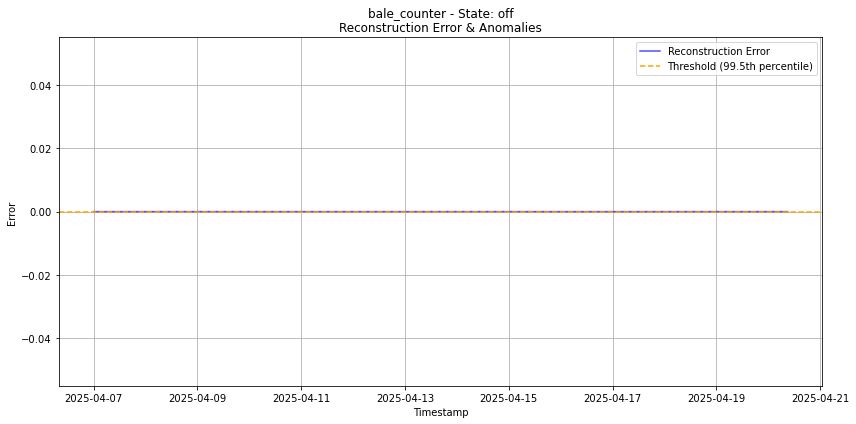

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Threshold for ../test_cases/saved_models/lstm_idle_bale_counter.h5: 0.020992 (99.5th percentile)


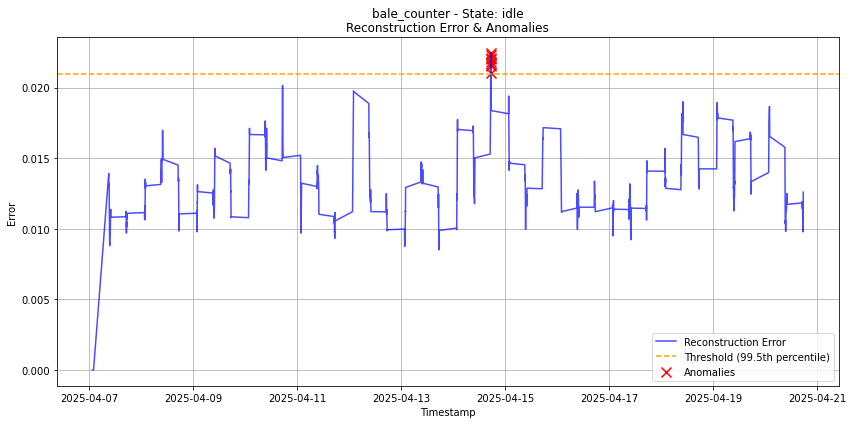

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Threshold for ../test_cases/saved_models/lstm_run_bale_counter.h5: 0.013727 (99.5th percentile)


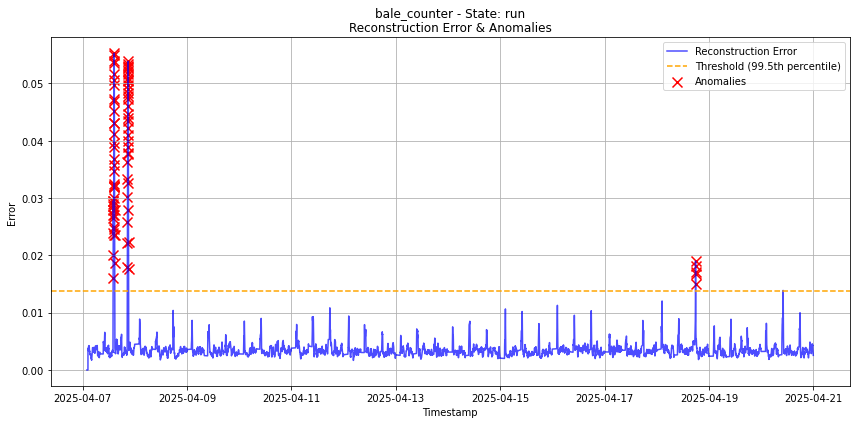

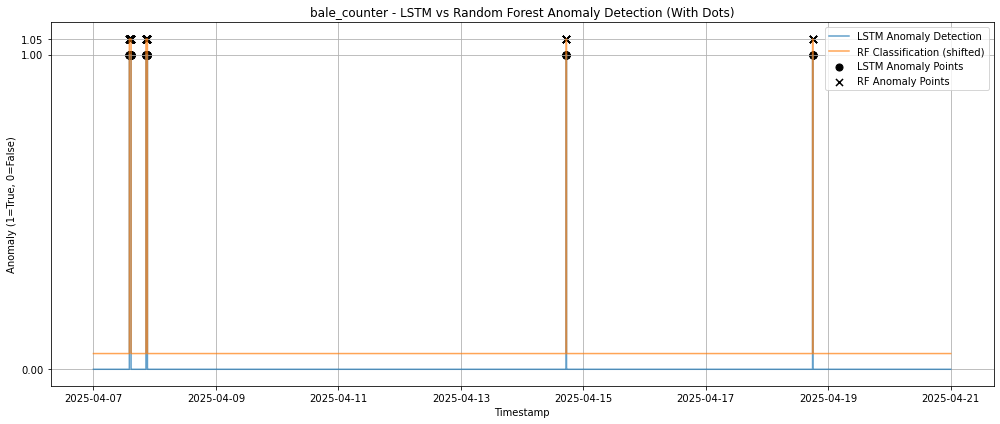

⏱️ Time taken for bale_counter: 7.07 seconds

Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Threshold for ../test_cases/saved_models/lstm_off.h5: 0.050289 (99.5th percentile)


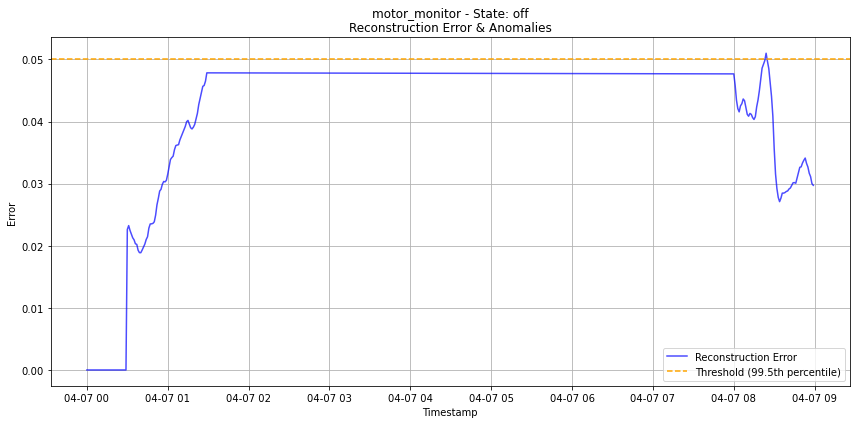

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Threshold for ../test_cases/saved_models/lstm_idle.h5: 0.065556 (99.5th percentile)


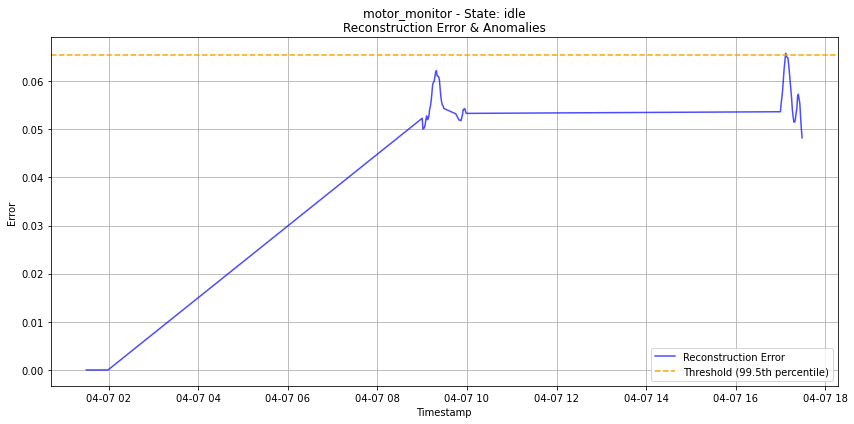

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Threshold for ../test_cases/saved_models/lstm_run.h5: 59054.572309 (99.5th percentile)


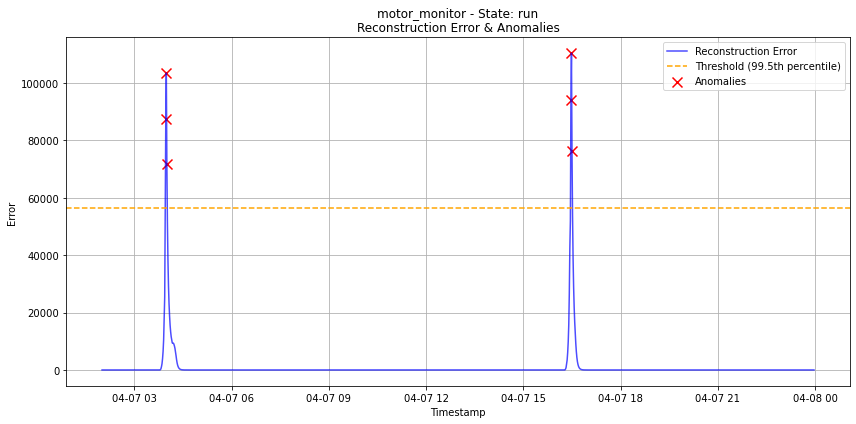

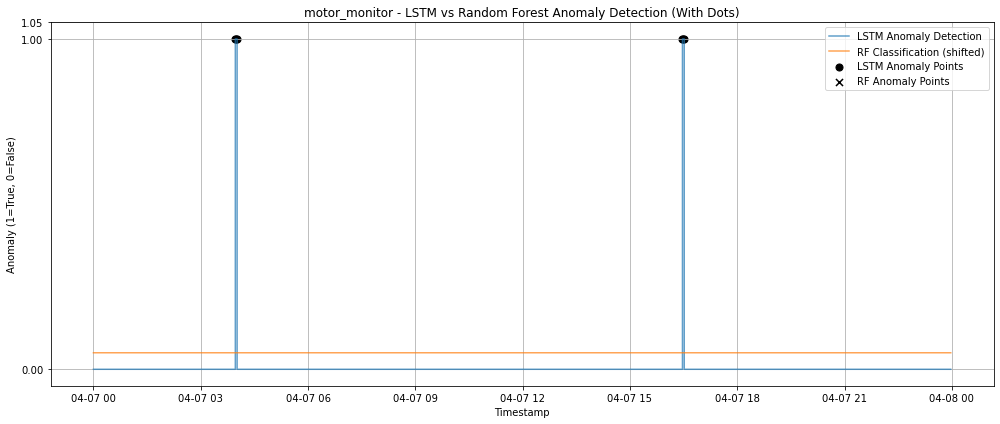

⏱️ Time taken for motor_monitor: 2.86 seconds

Processing device: output_sensor

output_sensor - Auto-detected features: ['output']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Threshold for ../test_cases/saved_models/lstm_long_fiber.h5: 0.026203 (99.5th percentile)


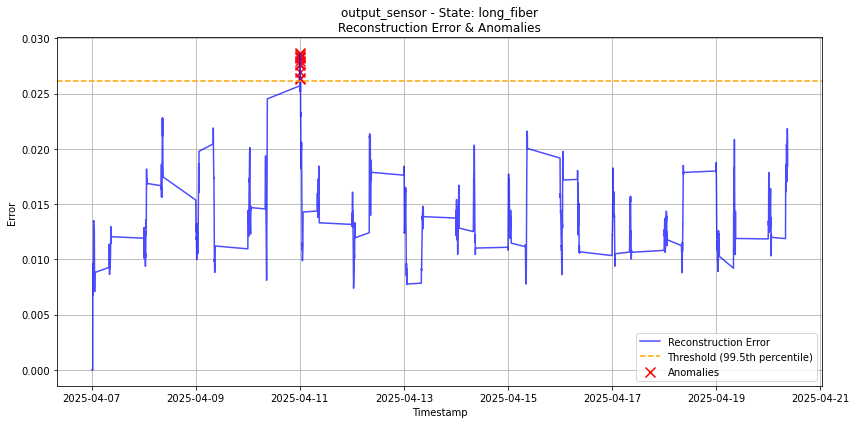

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Threshold for ../test_cases/saved_models/lstm_short_fiber.h5: 0.039669 (99.5th percentile)


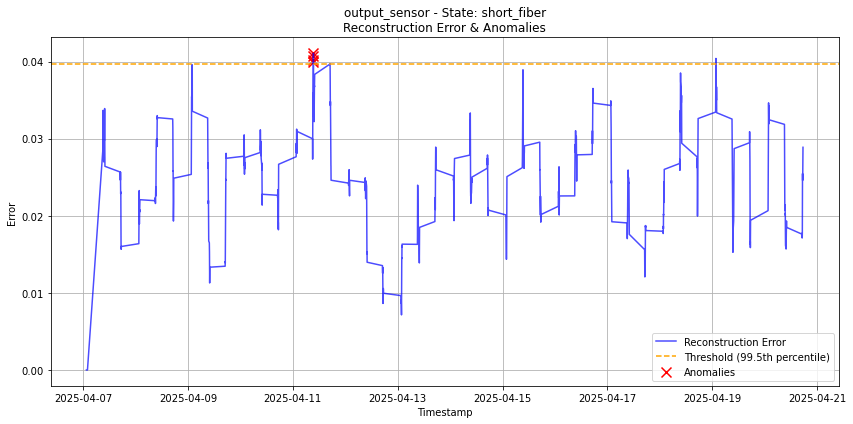

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Threshold for ../test_cases/saved_models/lstm_hurd.h5: 0.000486 (99.5th percentile)


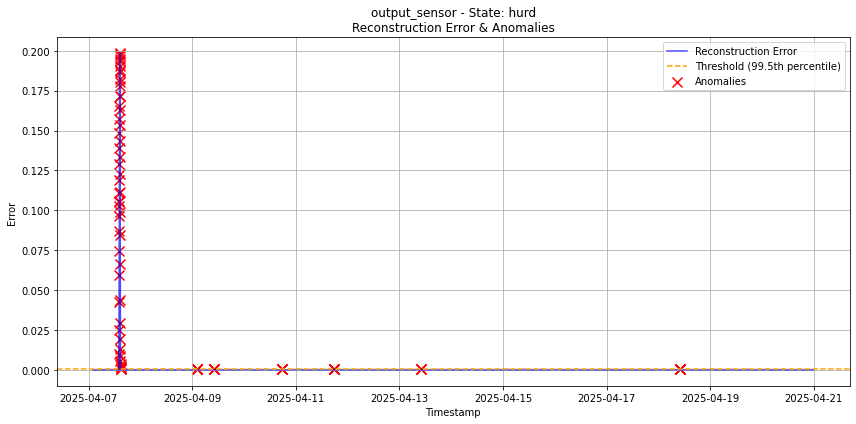

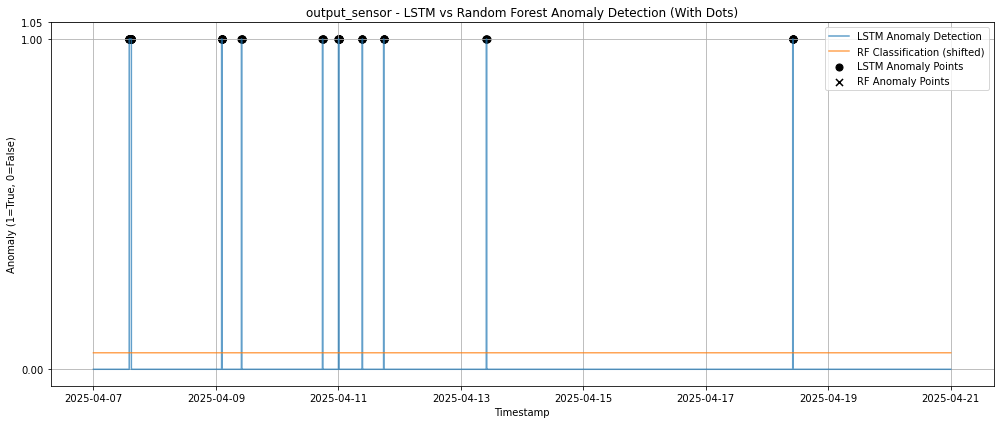

⏱️ Time taken for output_sensor: 6.98 seconds

Processing device: temperature_sensor

temperature_sensor - Auto-detected features: ['temperatureSensor1']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Threshold for ../test_cases/saved_models/lstm_off_temperature_sensor.h5: 0.000000 (99.5th percentile)


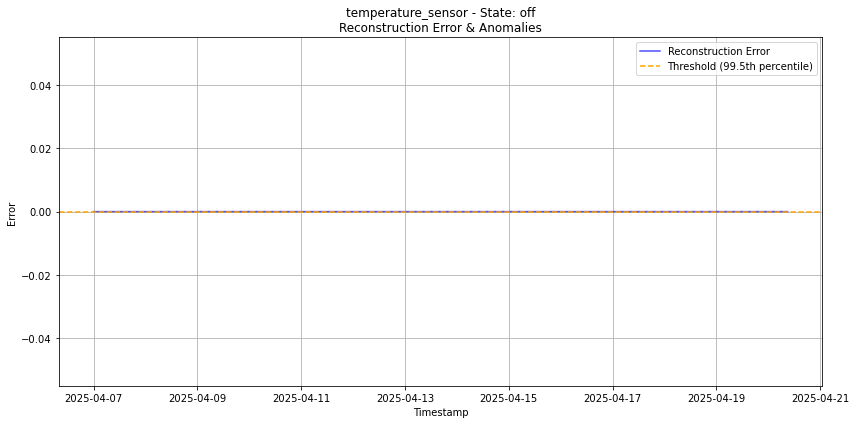

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Threshold for ../test_cases/saved_models/lstm_idle_temperature_sensor.h5: 0.000000 (99.5th percentile)


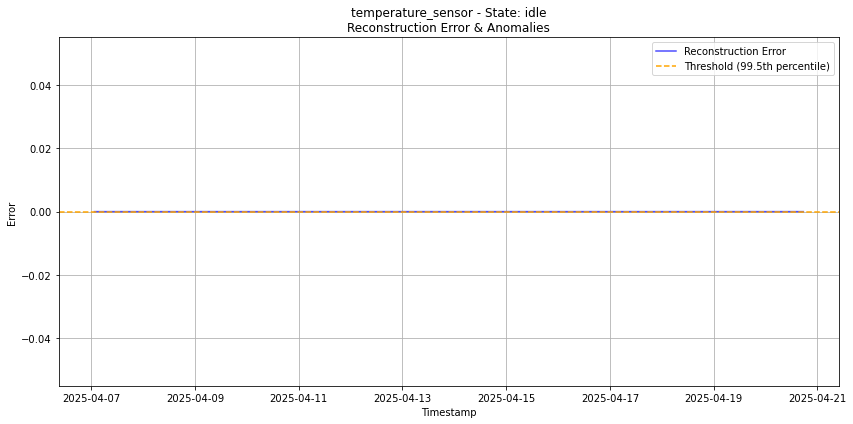

518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Threshold for ../test_cases/saved_models/lstm_run_temperature_sensor.h5: 0.002909 (99.5th percentile)


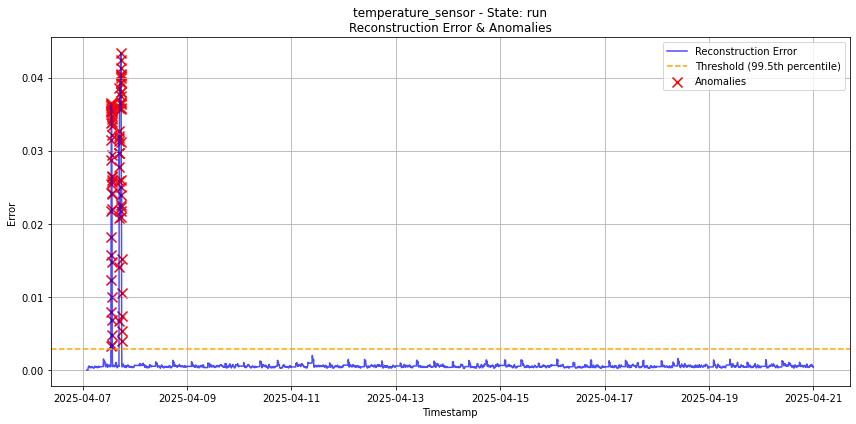

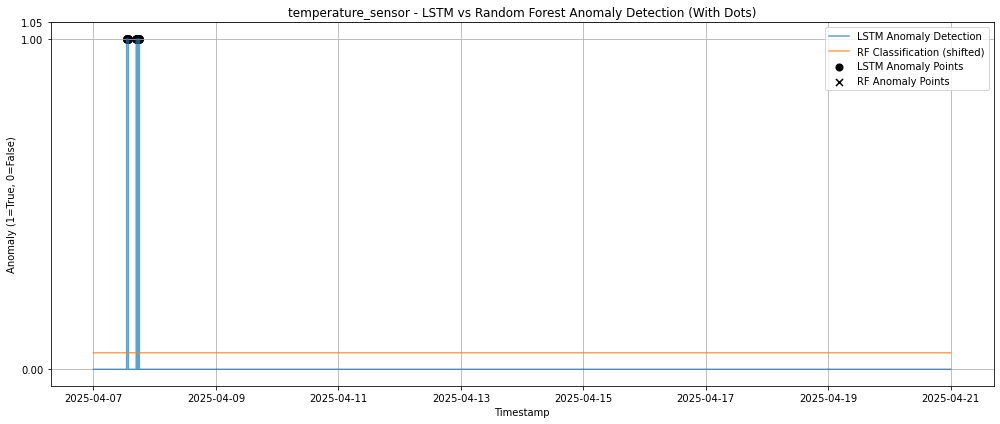

⏱️ Time taken for temperature_sensor: 6.62 seconds

✅ Processing complete for all devices!
⏱️ Total Execution Time: 26.01 seconds
💾 Start Memory: 763.91 MB
💾 End Memory: 771.80 MB
📈 Total Memory Growth: 7.89 MB


In [71]:

device_files = get_device_files()
all_results = {}

for device_type, csv_file in device_files:
    result = process_device(device_type, csv_file)
    if result is not None:
        all_results[device_type] = result

global_end_time = time.time()
end_memory = process.memory_info().rss / (1024 * 1024)

print("\n✅ Processing complete for all devices!")
print(f"⏱️ Total Execution Time: {global_end_time - global_start_time:.2f} seconds")
print(f"💾 Start Memory: {start_memory:.2f} MB")
print(f"💾 End Memory: {end_memory:.2f} MB")
print(f"📈 Total Memory Growth: {end_memory - start_memory:.2f} MB")
